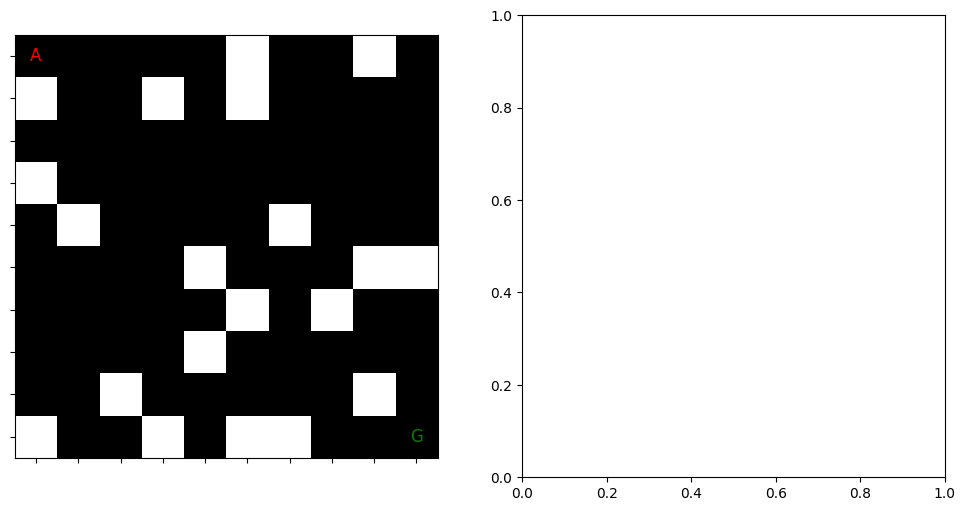

Episode 100: Total Reward: -26
Episode 200: Total Reward: -11
Episode 300: Total Reward: -9
Episode 400: Total Reward: -9
Episode 500: Total Reward: -13
Episode 600: Total Reward: -15
Episode 700: Total Reward: -7
Episode 800: Total Reward: -7
Episode 900: Total Reward: -9
Episode 1000: Total Reward: -9


In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt
from gym import Env, spaces

# Define a custom GridWorld environment
class GridWorldEnv(Env):
    def __init__(self, grid_size=10):
        super(GridWorldEnv, self).__init__()
        self.grid_size = grid_size
        self.state = (0, 0)  # Starting position
        self.goal = (grid_size - 1, grid_size - 1)  # Goal position
        self.obstacles = self._generate_obstacles()

        # Action space: Up, Down, Left, Right
        self.action_space = spaces.Discrete(4)

        # Observation space: Discrete states for the grid
        self.observation_space = spaces.Discrete(grid_size * grid_size)

    def _generate_obstacles(self):
        """Generate random obstacles."""
        obstacles = set()
        num_obstacles = int(self.grid_size * self.grid_size * 0.2)  # 20% obstacles
        while len(obstacles) < num_obstacles:
            obstacle = (random.randint(0, self.grid_size - 1), random.randint(0, self.grid_size - 1))
            if obstacle != (0, 0) and obstacle != self.goal:
                obstacles.add(obstacle)
        return obstacles

    def reset(self):
        self.state = (0, 0)
        return self._state_to_index(self.state)

    def step(self, action):
        x, y = self.state

        # Define actions: 0=Up, 1=Down, 2=Left, 3=Right
        if action == 0:  # Up
            x = max(0, x - 1)
        elif action == 1:  # Down
            x = min(self.grid_size - 1, x + 1)
        elif action == 2:  # Left
            y = max(0, y - 1)
        elif action == 3:  # Right
            y = min(self.grid_size - 1, y + 1)

        # Update state only if not an obstacle
        new_state = (x, y)
        if new_state not in self.obstacles:
            self.state = new_state

        # Calculate reward
        reward = -1  # Step penalty
        done = False
        if self.state == self.goal:
            reward = 10  # Goal reward
            done = True

        return self._state_to_index(self.state), reward, done, {}

    def _state_to_index(self, state):
        """Convert (x, y) state to a single integer index."""
        return state[0] * self.grid_size + state[1]

    def _index_to_state(self, index):
        """Convert a single integer index back to (x, y) state."""
        return divmod(index, self.grid_size)

    def render(self, ax):
        """Visualize the grid."""
        grid = np.zeros((self.grid_size, self.grid_size), dtype=str)
        grid[:, :] = '.'
        for obs in self.obstacles:
            grid[obs] = 'X'
        grid[self.goal] = 'G'
        x, y = self.state
        grid[x, y] = 'A'
        ax.clear()
        ax.set_xticks(range(self.grid_size))
        ax.set_yticks(range(self.grid_size))
        ax.imshow(grid == 'X', cmap='gray', origin='upper')
        ax.text(y, x, 'A', ha='center', va='center', color='red', fontsize=12)
        ax.text(self.goal[1], self.goal[0], 'G', ha='center', va='center', color='green', fontsize=12)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        plt.pause(0.1)

# Q-Learning Algorithm
def q_learning(env, episodes=1000, alpha=0.1, gamma=0.99, epsilon=0.1):
    q_table = np.zeros((env.observation_space.n, env.action_space.n))
    rewards = []

    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    grid_ax, reward_ax = axs
    plt.ion()

    for episode in range(episodes):
        state = env.reset()
        done = False
        total_reward = 0

        while not done:
            if random.uniform(0, 1) < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(q_table[state])

            next_state, reward, done, _ = env.step(action)

            q_table[state, action] += alpha * (
                reward + gamma * np.max(q_table[next_state]) - q_table[state, action]
            )

            state = next_state
            total_reward += reward

            if episode % 100 == 0:  # Show every 100 episodes
                env.render(grid_ax)

        rewards.append(total_reward)

        if (episode + 1) % 100 == 0:
            print(f"Episode {episode + 1}: Total Reward: {total_reward}")

        # Update reward graph
        reward_ax.clear()
        reward_ax.plot(rewards, label="Rewards")
        reward_ax.set_title("Cumulative Rewards over Episodes")
        reward_ax.set_xlabel("Episode")
        reward_ax.set_ylabel("Total Reward")
        reward_ax.legend()

    plt.ioff()
    plt.show()

    return q_table, rewards

# Main execution
if __name__ == "__main__":
    env = GridWorldEnv(grid_size=10)
    q_table, rewards = q_learning(env, episodes=1000)

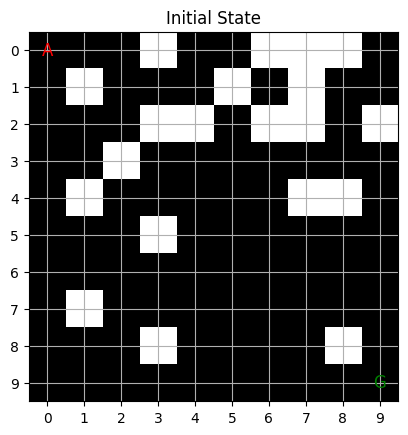

Episode 100: Total Reward: -16
Episode 200: Total Reward: -13
Episode 300: Total Reward: -9
Episode 400: Total Reward: -8
Episode 500: Total Reward: -8


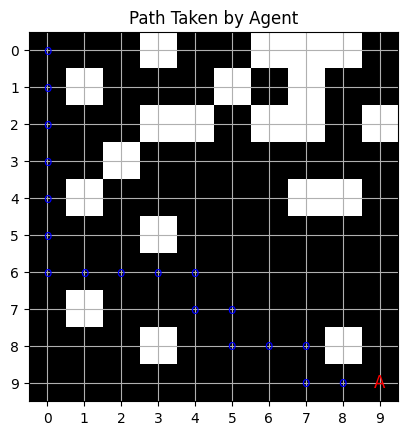

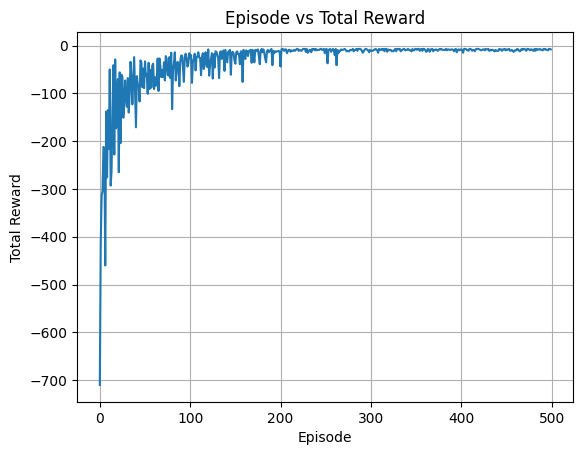

In [3]:
import numpy as np
import random
import matplotlib.pyplot as plt
from gym import Env, spaces

class GridWorldEnv(Env):
    def __init__(self, grid_size=10):
        super(GridWorldEnv, self).__init__()
        self.grid_size = grid_size
        self.state = (0, 0)  # Starting position
        self.goal = (grid_size - 1, grid_size - 1)  # Goal position
        self.obstacles = self._generate_obstacles()
        self.path = []

        # Action space: Up, Down, Left, Right
        self.action_space = spaces.Discrete(4)

        # Observation space: Discrete states for the grid
        self.observation_space = spaces.Discrete(grid_size * grid_size)

    def _generate_obstacles(self):
        """Generate random obstacles."""
        obstacles = set()
        num_obstacles = int(self.grid_size * self.grid_size * 0.2)  # 20% obstacles
        while len(obstacles) < num_obstacles:
            obstacle = (random.randint(0, self.grid_size - 1), random.randint(0, self.grid_size - 1))
            if obstacle != (0, 0) and obstacle != self.goal:
                obstacles.add(obstacle)
        return obstacles

    def reset(self):
        self.state = (0, 0)
        self.path = [self.state]
        return self._state_to_index(self.state)

    def step(self, action):
        x, y = self.state

        # Define actions: 0=Up, 1=Down, 2=Left, 3=Right
        if action == 0:  # Up
            x = max(0, x - 1)
        elif action == 1:  # Down
            x = min(self.grid_size - 1, x + 1)
        elif action == 2:  # Left
            y = max(0, y - 1)
        elif action == 3:  # Right
            y = min(self.grid_size - 1, y + 1)

        # Update state only if not an obstacle
        new_state = (x, y)
        if new_state not in self.obstacles:
            self.state = new_state
            self.path.append(self.state)

        # Calculate reward
        reward = -1  # Step penalty
        done = False
        if self.state == self.goal:
            reward = 10  # Goal reward
            done = True

        return self._state_to_index(self.state), reward, done, {}

    def _state_to_index(self, state):
        """Convert (x, y) state to a single integer index."""
        return state[0] * self.grid_size + state[1]

    def render(self, title="Grid", path=None):
        """Visualize the grid."""
        grid = np.zeros((self.grid_size, self.grid_size), dtype=str)
        grid[:, :] = '.'
        for obs in self.obstacles:
            grid[obs] = 'X'
        grid[self.goal] = 'G'
        if path:
            for p in path:
                grid[p] = 'o'
        x, y = self.state
        grid[x, y] = 'A'

        plt.imshow(grid == 'X', cmap='gray', origin='upper')
        plt.xticks(range(self.grid_size))
        plt.yticks(range(self.grid_size))
        for (i, j), val in np.ndenumerate(grid):
            if val == 'A':
                plt.text(j, i, val, ha='center', va='center', color='red', fontsize=12)
            elif val == 'G':
                plt.text(j, i, val, ha='center', va='center', color='green', fontsize=12)
            elif val == 'o':
                plt.text(j, i, val, ha='center', va='center', color='blue', fontsize=10)
        plt.title(title)
        plt.grid()
        plt.show()

# Q-Learning Algorithm
def q_learning(env, episodes=500, alpha=0.1, gamma=0.99, epsilon=0.1):
    q_table = np.zeros((env.observation_space.n, env.action_space.n))
    rewards = []

    # Plot initial state of the grid
    env.render(title="Initial State")

    for episode in range(episodes):
        state = env.reset()
        done = False
        total_reward = 0

        while not done:
            if random.uniform(0, 1) < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(q_table[state])

            next_state, reward, done, _ = env.step(action)

            q_table[state, action] += alpha * (
                reward + gamma * np.max(q_table[next_state]) - q_table[state, action]
            )

            state = next_state
            total_reward += reward

        rewards.append(total_reward)

        if (episode + 1) % 100 == 0:
            print(f"Episode {episode + 1}: Total Reward: {total_reward}")

    # Plot the path of the agent
    env.render(title="Path Taken by Agent", path=env.path)

    # Plot episode vs reward graph
    plt.plot(rewards)
    plt.title("Episode vs Total Reward")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.grid()
    plt.show()

    return q_table, rewards

# Main execution
if __name__ == "__main__":
    env = GridWorldEnv(grid_size=10)
    q_table, rewards = q_learning(env, episodes=500)

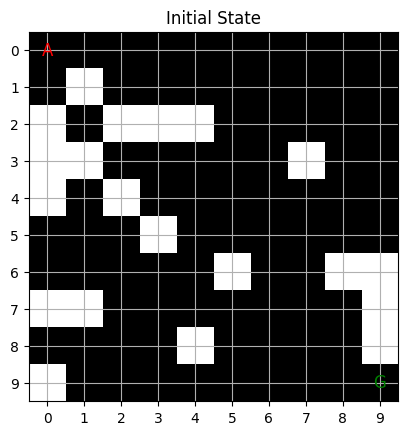

Episode 100: Total Reward: -7
Episode 200: Total Reward: 3
Episode 300: Total Reward: 3
Episode 400: Total Reward: 2
Episode 500: Total Reward: -6


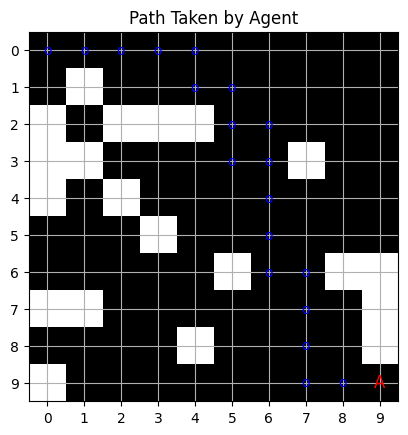

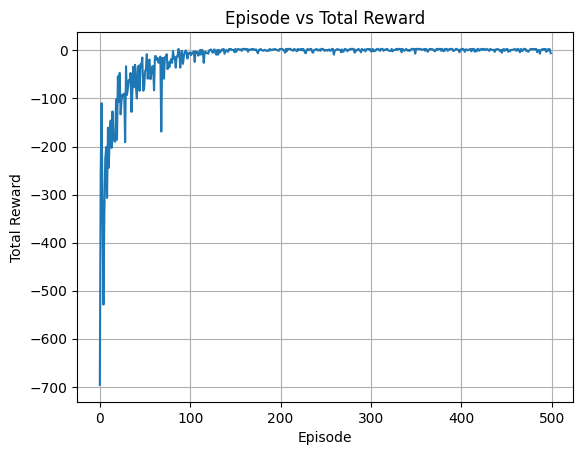

In [4]:
import numpy as np
import random
import matplotlib.pyplot as plt
from gym import Env, spaces

class GridWorldEnv(Env):
    def __init__(self, grid_size=10):
        super(GridWorldEnv, self).__init__()
        self.grid_size = grid_size
        self.state = (0, 0)  # Starting position
        self.goal = (grid_size - 1, grid_size - 1)  # Goal position
        self.obstacles = self._generate_obstacles()
        self.path = []

        # Action space: Up, Down, Left, Right
        self.action_space = spaces.Discrete(4)

        # Observation space: Discrete states for the grid
        self.observation_space = spaces.Discrete(grid_size * grid_size)

    def _generate_obstacles(self):
        """Generate random obstacles."""
        obstacles = set()
        num_obstacles = int(self.grid_size * self.grid_size * 0.2)  # 20% obstacles
        while len(obstacles) < num_obstacles:
            obstacle = (random.randint(0, self.grid_size - 1), random.randint(0, self.grid_size - 1))
            if obstacle != (0, 0) and obstacle != self.goal:
                obstacles.add(obstacle)
        return obstacles

    def reset(self):
        self.state = (0, 0)
        self.path = [self.state]
        return self._state_to_index(self.state)

    def step(self, action):
        x, y = self.state

        # Define actions: 0=Up, 1=Down, 2=Left, 3=Right
        if action == 0:  # Up
            x = max(0, x - 1)
        elif action == 1:  # Down
            x = min(self.grid_size - 1, x + 1)
        elif action == 2:  # Left
            y = max(0, y - 1)
        elif action == 3:  # Right
            y = min(self.grid_size - 1, y + 1)

        # Update state only if not an obstacle
        new_state = (x, y)
        if new_state not in self.obstacles:
            self.state = new_state
            self.path.append(self.state)

        # Calculate reward
        reward = -1  # Step penalty
        done = False
        if self.state == self.goal:
            reward = 20  # Positive reward for reaching the goal
            done = True

        return self._state_to_index(self.state), reward, done, {}

    def _state_to_index(self, state):
        return state[0] * self.grid_size + state[1]

    def render(self, title="Grid", path=None):
        grid = np.zeros((self.grid_size, self.grid_size), dtype=str)
        grid[:, :] = '.'
        for obs in self.obstacles:
            grid[obs] = 'X'
        grid[self.goal] = 'G'
        if path:
            for p in path:
                grid[p] = 'o'
        x, y = self.state
        grid[x, y] = 'A'

        plt.imshow(grid == 'X', cmap='gray', origin='upper')
        plt.xticks(range(self.grid_size))
        plt.yticks(range(self.grid_size))
        for (i, j), val in np.ndenumerate(grid):
            if val == 'A':
                plt.text(j, i, val, ha='center', va='center', color='red', fontsize=12)
            elif val == 'G':
                plt.text(j, i, val, ha='center', va='center', color='green', fontsize=12)
            elif val == 'o':
                plt.text(j, i, val, ha='center', va='center', color='blue', fontsize=10)
        plt.title(title)
        plt.grid()
        plt.show()

# Q-Learning Algorithm
def q_learning(env, episodes=500, alpha=0.1, gamma=0.99, epsilon=0.1):
    q_table = np.zeros((env.observation_space.n, env.action_space.n))
    rewards = []

    # Plot initial state of the grid
    env.render(title="Initial State")

    for episode in range(episodes):
        state = env.reset()
        done = False
        total_reward = 0

        while not done:
            if random.uniform(0, 1) < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(q_table[state])

            next_state, reward, done, _ = env.step(action)

            q_table[state, action] += alpha * (
                reward + gamma * np.max(q_table[next_state]) - q_table[state, action]
            )

            state = next_state
            total_reward += reward

        rewards.append(total_reward)

        if (episode + 1) % 100 == 0:
            print(f"Episode {episode + 1}: Total Reward: {total_reward}")

    # Plot the path of the agent
    env.render(title="Path Taken by Agent", path=env.path)

    # Plot episode vs reward graph
    plt.plot(rewards)
    plt.title("Episode vs Total Reward")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.grid()
    plt.show()

    return q_table, rewards

# Main execution
if __name__ == "__main__":
    env = GridWorldEnv(grid_size=10)
    q_table, rewards = q_learning(env, episodes=500)

Episode 1000: Total Reward: 1
Episode 2000: Total Reward: 1
Episode 3000: Total Reward: 1
Episode 4000: Total Reward: 1
Episode 5000: Total Reward: 1


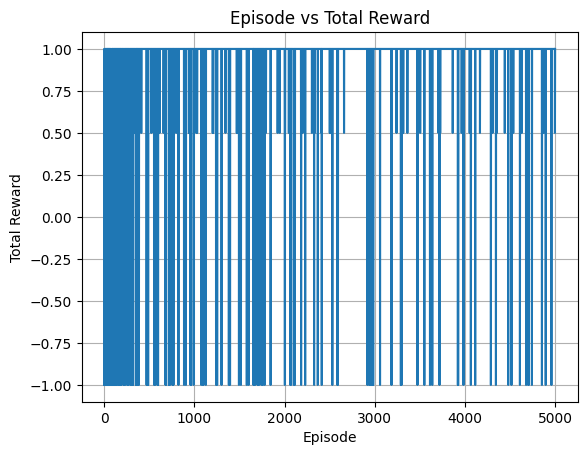

In [5]:
import numpy as np
import random
import matplotlib.pyplot as plt

class TicTacToe:
    def __init__(self):
        self.board = [' '] * 9  # 1D representation of the 3x3 board
        self.current_player = 'X'

    def reset(self):
        self.board = [' '] * 9
        self.current_player = 'X'
        return self.get_state()

    def get_state(self):
        """Convert the board to a string state representation."""
        return ''.join(self.board)

    def available_actions(self):
        """Return a list of available actions (empty spaces)."""
        return [i for i in range(9) if self.board[i] == ' ']

    def step(self, action):
        """Take a step by playing a move and return the result."""
        if self.board[action] != ' ':
            raise ValueError("Invalid move")

        self.board[action] = self.current_player
        winner = self.check_winner()
        done = winner is not None or ' ' not in self.board

        reward = 0
        if winner == 'X':  # The RL agent wins
            reward = 1
        elif winner == 'O':  # The opponent wins
            reward = -1
        elif done:  # Draw
            reward = 0.5

        self.current_player = 'O' if self.current_player == 'X' else 'X'
        return self.get_state(), reward, done

    def check_winner(self):
        """Check if there's a winner on the board."""
        win_conditions = [
            [0, 1, 2], [3, 4, 5], [6, 7, 8],  # Rows
            [0, 3, 6], [1, 4, 7], [2, 5, 8],  # Columns
            [0, 4, 8], [2, 4, 6],             # Diagonals
        ]
        for condition in win_conditions:
            if self.board[condition[0]] == self.board[condition[1]] == self.board[condition[2]] != ' ':
                return self.board[condition[0]]  # Return 'X' or 'O'
        return None

    def render(self):
        """Display the board."""
        print("\n")
        for i in range(3):
            print('|'.join(self.board[i * 3:(i + 1) * 3]))
            if i < 2:
                print('-' * 5)
        print("\n")


def q_learning_tic_tac_toe(episodes=10000, alpha=0.1, gamma=0.9, epsilon=0.1):
    env = TicTacToe()
    q_table = {}

    def get_q(state, action):
        return q_table.get((state, action), 0)

    rewards = []

    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        done = False

        while not done:
            # Epsilon-greedy action selection
            if random.uniform(0, 1) < epsilon:
                action = random.choice(env.available_actions())
            else:
                q_values = [get_q(state, a) for a in env.available_actions()]
                max_q = max(q_values)
                action = random.choice([a for a, q in zip(env.available_actions(), q_values) if q == max_q])

            next_state, reward, done = env.step(action)

            if done:
                q_table[(state, action)] = reward
            else:
                max_next_q = max([get_q(next_state, a) for a in env.available_actions()])
                q_table[(state, action)] = get_q(state, action) + alpha * (reward + gamma * max_next_q - get_q(state, action))

            state = next_state
            total_reward += reward

        rewards.append(total_reward)

        if (episode + 1) % 1000 == 0:
            print(f"Episode {episode + 1}: Total Reward: {total_reward}")

    return q_table, rewards

# Train the agent
q_table, rewards = q_learning_tic_tac_toe(episodes=5000)

# Plot rewards
plt.plot(rewards)
plt.title("Episode vs Total Reward")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid()
plt.show()

Episode 1000: Total Reward: 1
Episode 2000: Total Reward: -1
Episode 3000: Total Reward: 1
Episode 4000: Total Reward: 1
Episode 5000: Total Reward: 1


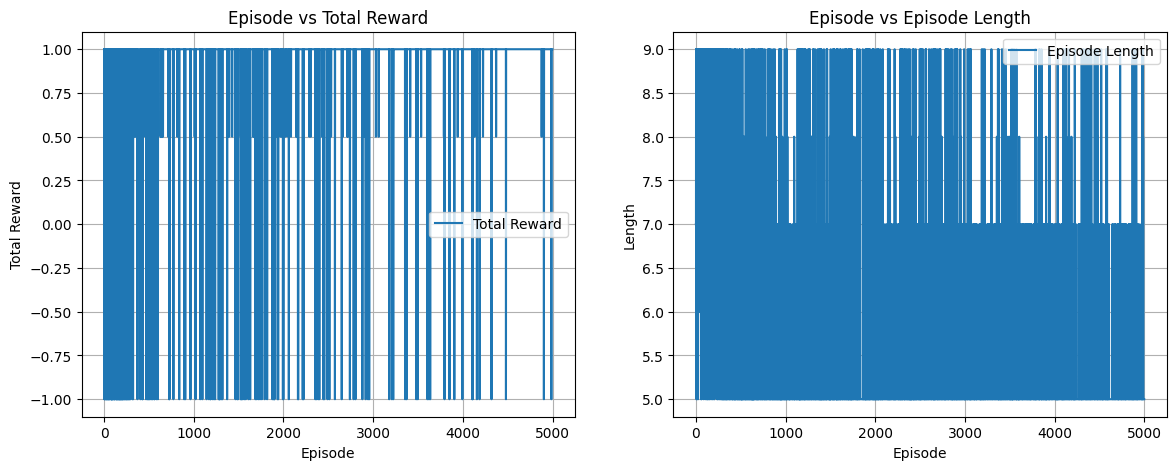

In [6]:
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib import colors

class TicTacToe:
    def __init__(self):
        self.board = [' '] * 9
        self.current_player = 'X'

    def reset(self):
        self.board = [' '] * 9
        self.current_player = 'X'
        return self.get_state()

    def get_state(self):
        return ''.join(self.board)

    def available_actions(self):
        return [i for i in range(9) if self.board[i] == ' ']

    def step(self, action):
        if self.board[action] != ' ':
            raise ValueError("Invalid move")

        self.board[action] = self.current_player
        winner = self.check_winner()
        done = winner is not None or ' ' not in self.board

        reward = 0
        if winner == 'X':
            reward = 1
        elif winner == 'O':
            reward = -1
        elif done:
            reward = 0.5

        self.current_player = 'O' if self.current_player == 'X' else 'X'
        return self.get_state(), reward, done

    def check_winner(self):
        win_conditions = [
            [0, 1, 2], [3, 4, 5], [6, 7, 8],  # Rows
            [0, 3, 6], [1, 4, 7], [2, 5, 8],  # Columns
            [0, 4, 8], [2, 4, 6],             # Diagonals
        ]
        for condition in win_conditions:
            if self.board[condition[0]] == self.board[condition[1]] == self.board[condition[2]] != ' ':
                return self.board[condition[0]]
        return None

    def render(self):
        """Display the board using Matplotlib."""
        board_reshaped = np.array(self.board).reshape(3, 3)
        fig, ax = plt.subplots(figsize=(4, 4))
        cmap = colors.ListedColormap(['white', 'red', 'blue'])
        grid_data = [[0 if cell == ' ' else 1 if cell == 'X' else 2 for cell in row] for row in board_reshaped]
        ax.matshow(grid_data, cmap=cmap, alpha=0.2)

        # Annotate cells with X or O
        for i in range(3):
            for j in range(3):
                value = board_reshaped[i, j]
                if value != ' ':
                    ax.text(j, i, value, ha='center', va='center', fontsize=20, color='black')

        ax.set_xticks([])
        ax.set_yticks([])
        plt.show()


def q_learning_tic_tac_toe(episodes=10000, alpha=0.1, gamma=0.9, epsilon=0.1):
    env = TicTacToe()
    q_table = {}

    def get_q(state, action):
        return q_table.get((state, action), 0)

    rewards = []
    episode_lengths = []

    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        steps = 0
        done = False

        while not done:
            steps += 1
            if random.uniform(0, 1) < epsilon:
                action = random.choice(env.available_actions())
            else:
                q_values = [get_q(state, a) for a in env.available_actions()]
                max_q = max(q_values)
                action = random.choice([a for a, q in zip(env.available_actions(), q_values) if q == max_q])

            next_state, reward, done = env.step(action)

            if done:
                q_table[(state, action)] = reward
            else:
                max_next_q = max([get_q(next_state, a) for a in env.available_actions()])
                q_table[(state, action)] = get_q(state, action) + alpha * (reward + gamma * max_next_q - get_q(state, action))

            state = next_state
            total_reward += reward

        rewards.append(total_reward)
        episode_lengths.append(steps)

        if (episode + 1) % 1000 == 0:
            print(f"Episode {episode + 1}: Total Reward: {total_reward}")

    return q_table, rewards, episode_lengths


# Train the agent
q_table, rewards, episode_lengths = q_learning_tic_tac_toe(episodes=5000)

# Plot results
plt.figure(figsize=(14, 5))

# Total rewards per episode
plt.subplot(1, 2, 1)
plt.plot(rewards, label="Total Reward")
plt.title("Episode vs Total Reward")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid()
plt.legend()

# Episode lengths
plt.subplot(1, 2, 2)
plt.plot(episode_lengths, label="Episode Length")
plt.title("Episode vs Episode Length")
plt.xlabel("Episode")
plt.ylabel("Length")
plt.grid()
plt.legend()

plt.show()

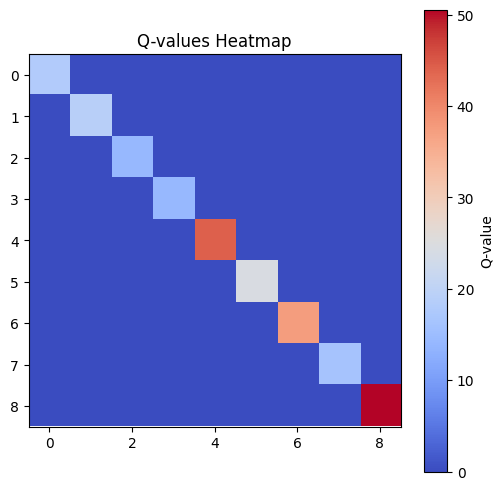

Game started! You are 'O'.


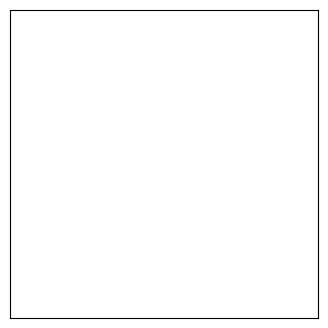

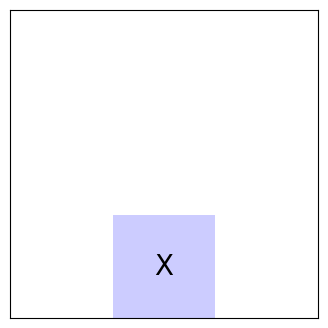

Your move (0-8): 0


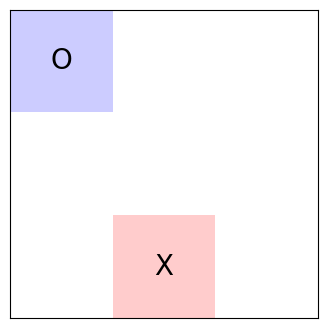

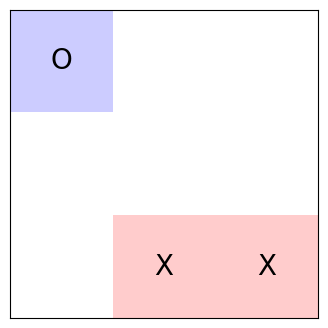

Your move (0-8): 5


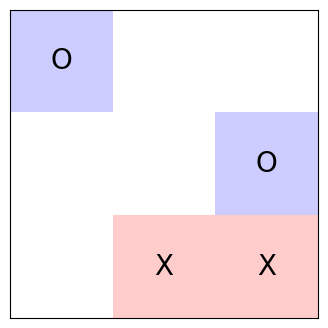

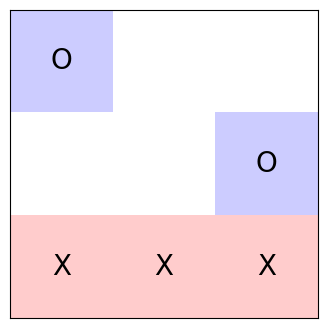

Agent wins!


In [8]:
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib import colors


class TicTacToe:
    def __init__(self):
        self.board = [' '] * 9
        self.current_player = 'X'

    def reset(self):
        self.board = [' '] * 9
        self.current_player = 'X'
        return self.get_state()

    def get_state(self):
        return ''.join(self.board)

    def available_actions(self):
        return [i for i in range(9) if self.board[i] == ' ']

    def step(self, action):
        if self.board[action] != ' ':
            raise ValueError("Invalid move")

        self.board[action] = self.current_player
        winner = self.check_winner()
        done = winner is not None or ' ' not in self.board

        reward = 0
        if winner == 'X':
            reward = 1
        elif winner == 'O':
            reward = -1
        elif done:
            reward = 0.5

        self.current_player = 'O' if self.current_player == 'X' else 'X'
        return self.get_state(), reward, done

    def check_winner(self):
        win_conditions = [
            [0, 1, 2], [3, 4, 5], [6, 7, 8],  # Rows
            [0, 3, 6], [1, 4, 7], [2, 5, 8],  # Columns
            [0, 4, 8], [2, 4, 6],             # Diagonals
        ]
        for condition in win_conditions:
            if self.board[condition[0]] == self.board[condition[1]] == self.board[condition[2]] != ' ':
                return self.board[condition[0]]
        return None

    def render(self):
        board_reshaped = np.array(self.board).reshape(3, 3)
        fig, ax = plt.subplots(figsize=(4, 4))
        cmap = colors.ListedColormap(['white', 'red', 'blue'])
        grid_data = [[0 if cell == ' ' else 1 if cell == 'X' else 2 for cell in row] for row in board_reshaped]
        ax.matshow(grid_data, cmap=cmap, alpha=0.2)

        # Annotate cells with X or O
        for i in range(3):
            for j in range(3):
                value = board_reshaped[i, j]
                if value != ' ':
                    ax.text(j, i, value, ha='center', va='center', fontsize=20, color='black')

        ax.set_xticks([])
        ax.set_yticks([])
        plt.show()


def q_learning_tic_tac_toe(episodes=10000, alpha=0.1, gamma=0.9, epsilon=0.1):
    env = TicTacToe()
    q_table = {}

    def get_q(state, action):
        return q_table.get((state, action), 0)

    rewards = []

    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        done = False

        while not done:
            if random.uniform(0, 1) < epsilon:
                action = random.choice(env.available_actions())
            else:
                q_values = [get_q(state, a) for a in env.available_actions()]
                max_q = max(q_values)
                action = random.choice([a for a, q in zip(env.available_actions(), q_values) if q == max_q])

            next_state, reward, done = env.step(action)

            if done:
                q_table[(state, action)] = reward
            else:
                max_next_q = max([get_q(next_state, a) for a in env.available_actions()])
                q_table[(state, action)] = get_q(state, action) + alpha * (reward + gamma * max_next_q - get_q(state, action))

            state = next_state
            total_reward += reward

        rewards.append(total_reward)

    return q_table, rewards


# Train the agent
q_table, rewards = q_learning_tic_tac_toe(episodes=5000)

# Visualization of Q-values as a heatmap
def visualize_q_values(q_table):
    heatmap = np.zeros((9, 9))
    for (state, action), value in q_table.items():
        heatmap[int(action), int(action)] += value

    plt.figure(figsize=(6, 6))
    plt.title("Q-values Heatmap")
    plt.imshow(heatmap, cmap="coolwarm", interpolation="nearest")
    plt.colorbar(label="Q-value")
    plt.show()


# Play against the agent
def play_against_agent(q_table):
    env = TicTacToe()
    state = env.reset()

    print("Game started! You are 'O'.")
    while True:
        env.render()

        if env.current_player == 'O':
            try:
                action = int(input("Your move (0-8): "))
                if action not in env.available_actions():
                    raise ValueError("Invalid move!")
            except ValueError:
                print("Please enter a valid move.")
                continue
        else:
            q_values = [q_table.get((state, a), 0) for a in env.available_actions()]
            action = env.available_actions()[np.argmax(q_values)]

        state, reward, done = env.step(action)
        if done:
            env.render()
            if reward == 1:
                print("Agent wins!")
            elif reward == -1:
                print("You win!")
            else:
                print("It's a draw!")
            break


# Visualize Q-values and play a game
visualize_q_values(q_table)
play_against_agent(q_table)